# Data Loading

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import sys
import os

root_path = os.path.abspath("..")   # go up one directory
sys.path.append(root_path)

from Project.param import *
from Project.data import prepare_stock_data

ModuleNotFoundError: No module named 'param'

def load_and_prepare_data(ticker: str, start: str, end: str,
                          test_size=0.15, valid_size=0.15,
                          drop_cols=None):
    """
    Load stock data, compute selected features, flatten columns,
    scale them, split into train/validation/test sets,
    and drop unnecessary columns.

    Args:
        ticker (str): Stock ticker
        start (str): Start date (YYYY-MM-DD)
        end (str): End date (YYYY-MM-DD)
        test_size (float): Fraction of data for test
        valid_size (float): Fraction of data for validation
        drop_cols (list): Columns to drop from X sets

    Returns:
        train_df, valid_df, test_df: Split and processed DataFrames
        scaler: fitted MinMaxScaler
    """

    if drop_cols is None:
        drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High', 'OpenInt']

    # -----------------------------
    # 1️⃣ Download data
    # -----------------------------
    df = yf.download(ticker, start=start, end=end)
    if df.empty:
        raise ValueError(f"No data downloaded for ticker {ticker}")
    df = df.dropna()

    # -----------------------------
    # 2️⃣ Compute indicators
    # -----------------------------
    df["return"] = df["Close"].pct_change()
    df["log_return"] = np.log1p(df["return"])
    df["SMA_5"] = df["Close"].rolling(5).mean()
    df["SMA_20"] = df["Close"].rolling(20).mean()
    df["Volatility_10"] = df["Close"].pct_change().rolling(10).std()

    delta = df["Close"].diff()
    gain = delta.clip(lower=0)
    loss = -1 * delta.clip(upper=0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df["RSI"] = 100 - (100 / (1 + rs))

    df = df.dropna()  # drop NaNs from rolling calculations

    # -----------------------------
    # 3️⃣ Flatten columns if MultiIndex
    # -----------------------------
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(filter(None, col)) for col in df.columns]

    # -----------------------------
    # 4️⃣ Scale features
    # -----------------------------
    scaler = MinMaxScaler()
    scaled_array = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(scaled_array, index=df.index, columns=df.columns)

    # -----------------------------
    # 5️⃣ Shift target for next-day prediction
    # -----------------------------
    df_scaled['Close'] = df_scaled['Close'].shift(-1)

    # -----------------------------
    # 6️⃣ Drop first rows due to rolling indicators & last row due to shift
    # -----------------------------
    df_scaled = df_scaled.iloc[33:-1].copy()
    df_scaled.index = range(len(df_scaled))

    # -----------------------------
    # 7️⃣ Split into train/valid/test
    # -----------------------------
    total_len = df_scaled.shape[0]
    test_split_idx  = int(total_len * (1 - test_size))
    valid_split_idx = int(total_len * (1 - (valid_size + test_size)))

    train_df = df_scaled.loc[:valid_split_idx].copy()
    valid_df = df_scaled.loc[valid_split_idx + 1:test_split_idx].copy()
    test_df  = df_scaled.loc[test_split_idx + 1:].copy()

    # -----------------------------
    # 8️⃣ Drop unwanted columns
    # -----------------------------
    for col_set in [train_df, valid_df, test_df]:
        for col in drop_cols:
            if col in col_set.columns:
                col_set.drop(columns=[col], inplace=True)

    return train_df, valid_df, test_df, scaler

In [ ]:
def load_data(ticker: str, start: str, end: str):
    """
    Load stock market data, compute selected features, scale them,
    and return only the chosen variables.

    Returns:
        df_scaled (pd.DataFrame): Scaled features
        scaler (MinMaxScaler): Fitted scaler
    """

    import yfinance as yf
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import MinMaxScaler

    # -----------------------------
    # 1️⃣ Download raw data
    # -----------------------------
    df = yf.download(ticker, start=start, end=end)

    if df.empty:
        raise ValueError(f"No data downloaded for ticker {ticker}")

    df = df.dropna()

    # -----------------------------
    # 2️⃣ Compute selected indicators
    # -----------------------------
    df["return"] = df["Close"].pct_change()
    df["log_return"] = np.log1p(df["return"])
    df["SMA_5"] = df["Close"].rolling(5).mean()
    df["SMA_20"] = df["Close"].rolling(20).mean()
    df["Volatility_10"] = df["Close"].pct_change().rolling(10).std()

    # RSI (14)
    delta = df["Close"].diff()
    gain = delta.clip(lower=0)
    loss = -1 * delta.clip(upper=0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df["RSI"] = 100 - (100 / (1 + rs))

    # -----------------------------
    # 3️⃣ Drop NaNs
    # -----------------------------
    df = df.dropna()

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(filter(None, col)) for col in df.columns]


    # -----------------------------
    # 5️⃣ Scale features
    # -----------------------------
    scaler = MinMaxScaler()
    scaled_array = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(scaled_array, index=df.index, columns=df.columns)

    return df_scaled, scaler


In [ ]:
df, _ = load_data(TICKER, START_DATE, END_DATE)

/var/folders/8y/wwgq01wx345gslv488wqly7m0000gn/T/ipykernel_74675/2178790727.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


In [ ]:
df

,Close_PPH,High_PPH,Low_PPH,Open_PPH,Volume_PPH,return,log_return,SMA_5,SMA_20,Volatility_10,RSI
Date,,,,,,,,,,,
2020-12-31,0.010249,0.000000,0.011220,0.000000,0.003152,0.609129,0.616833,0.000000,0.000000,0.253308,0.480701
2021-01-04,0.008499,0.005295,0.009474,0.023554,0.016127,0.490382,0.498510,0.005816,0.001358,0.235497,0.533951
2021-01-05,0.018749,0.011348,0.017204,0.012529,0.004032,0.601609,0.609367,0.012543,0.002175,0.255500,0.703551
2021-01-06,0.035248,0.034294,0.029421,0.016538,0.009529,0.658608,0.665868,0.021203,0.004379,0.124107,0.680166
2021-01-07,0.048997,0.042111,0.054104,0.044352,0.008796,0.632029,0.639547,0.031224,0.006172,0.076736,0.718616
...,...,...,...,...,...,...,...,...,...,...,...
2024-11-25,0.726241,0.734677,0.739971,0.736555,0.143527,0.541329,0.549387,0.714959,0.779556,0.474262,0.376467
2024-11-26,0.742845,0.740620,0.745580,0.750515,0.075722,0.614054,0.621721,0.728607,0.775507,0.445447,0.501171
2024-11-27,0.759182,0.761691,0.766148,0.757763,0.128280,0.611588,0.619273,0.742470,0.772863,0.462712,0.433798


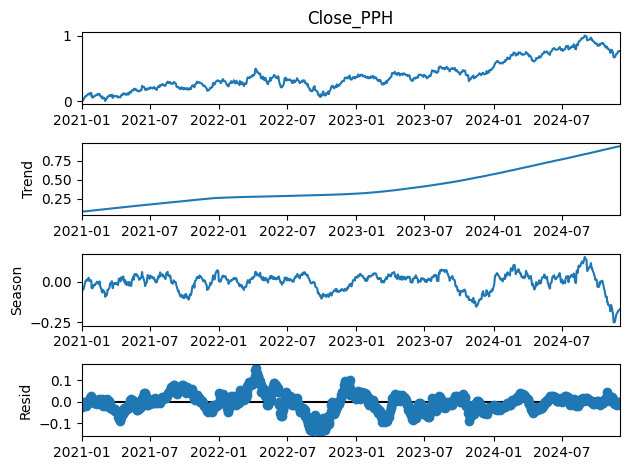

In [ ]:
ts = df['Close_PPH']

# STL decomposition
stl = STL(ts, period=252)  # ~trading days in a year
res = stl.fit()

# Plot components
res.plot()
plt.show()

# Access components
trend = res.trend
seasonal = res.seasonal
residual = res.resid

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

# Loop over all columns in df and add them as traces
for col in df.columns:
    fig.add_trace(
        go.Scatter(
            x=df.index,  # Date is the index
            y=df[col],
            name=col
        )
    )

# Optional: highlight 'Close' separately with lower opacity
if 'Close_PPH' in df.columns:
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df['Close_PPH'],
            name='Close_PPH',
            opacity=0.2
        )
    )

fig.update_layout(
    title="Stock Features Over Time",
    xaxis_title="Date",
    yaxis_title="Values",
    template="plotly_white"
)

fig.show()


In [ ]:
df.isna().sum()

Close_PPH        0
High_PPH         0
Low_PPH          0
Open_PPH         0
Volume_PPH       0
return           0
log_return       0
SMA_5            0
SMA_20           0
Volatility_10    0
RSI              0
dtype: int64

In [ ]:
df['Close_PPH'] = df['Close_PPH'].shift(-1)


df = df.iloc[33:] # Because of moving averages and MACD line
df = df[:-1]      # Because of shifting close price

df.index = range(len(df))

In [ ]:
df.isna().sum()

Close_PPH        0
High_PPH         0
Low_PPH          0
Open_PPH         0
Volume_PPH       0
return           0
log_return       0
SMA_5            0
SMA_20           0
Volatility_10    0
RSI              0
dtype: int64

In [ ]:
def split_and_plot(df: pd.DataFrame, test_size=0.15, valid_size=0.15, plot=True, target_col='Close'):
    """
    Split a DataFrame into train, validation, and test sets based on sizes,
    and optionally plot the splits.

    Args:
        df (pd.DataFrame): Input DataFrame with a Date index or 'Date' column.
        test_size (float): Fraction of data to use as test set.
        valid_size (float): Fraction of data to use as validation set.
        plot (bool): Whether to plot the splits using Plotly.
        target_col (str): Column to plot.

    Returns:
        train_df, valid_df, test_df: Split DataFrames
    """

    # -----------------------------
    # Compute split indices
    # -----------------------------
    total_len = df.shape[0]
    test_split_idx  = int(total_len * (1 - test_size))
    valid_split_idx = int(total_len * (1 - (valid_size + test_size)))

    # -----------------------------
    # Split the data
    # -----------------------------
    train_df = df.loc[:valid_split_idx].copy()
    valid_df = df.loc[valid_split_idx + 1:test_split_idx].copy()
    test_df  = df.loc[test_split_idx + 1:].copy()

    # -----------------------------
    # Optional plot
    # -----------------------------
    if plot:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=train_df.index if 'Date' not in df.columns else train_df['Date'],
                                 y=train_df[target_col], name='Training'))
        fig.add_trace(go.Scatter(x=valid_df.index if 'Date' not in df.columns else valid_df['Date'],
                                 y=valid_df[target_col], name='Validation'))
        fig.add_trace(go.Scatter(x=test_df.index if 'Date' not in df.columns else test_df['Date'],
                                 y=test_df[target_col], name='Test'))
        fig.update_layout(
            title=f"Train / Validation / Test Split ({target_col})",
            xaxis_title="Date",
            yaxis_title=target_col,
            template="plotly_white"
        )
        fig.show()

    return train_df, valid_df, test_df

In [ ]:
train_df, valid_df, test_df = split_and_plot(df, test_size=0.15, valid_size=0.15, target_col='Close_PPH')


In [ ]:
train_df.head()

,Close_PPH,High_PPH,Low_PPH,Open_PPH,Volume_PPH,return,log_return,SMA_5,SMA_20,Volatility_10,RSI
0,0.059996,0.075899,0.095492,0.093715,0.008943,0.409195,0.417086,0.102119,0.096368,0.264578,0.595848
1,0.049746,0.054970,0.073552,0.072918,0.011215,0.366270,0.373861,0.092653,0.093524,0.304752,0.464194
2,0.070246,0.045136,0.059340,0.063145,0.055197,0.414419,0.422338,0.082935,0.089614,0.286638,0.420430
3,0.048247,0.065057,0.069313,0.056631,0.003225,0.692029,0.698900,0.075684,0.087043,0.368289,0.481846
4,0.036748,0.057744,0.061335,0.075674,0.273714,0.309948,0.316959,0.067930,0.085991,0.419978,0.374234


In [ ]:
drop_cols = ['High_PPH','Low_PPH','Open_PPH','Volume_PPH']

train_df = train_df.drop(columns=drop_cols)
valid_df = valid_df.drop(columns=drop_cols)
test_df  = test_df.drop(columns=drop_cols)


In [ ]:
def split_features_labels(train_df, valid_df, test_df, target_col='Close'):
    """
    Split train, validation, and test DataFrames into features (X) and labels (y).

    Args:
        train_df (pd.DataFrame): Training set
        valid_df (pd.DataFrame): Validation set
        test_df (pd.DataFrame): Test set
        target_col (str): Column to use as target variable

    Returns:
        X_train, y_train, X_valid, y_valid, X_test, y_test
    """
    # Training set
    y_train = train_df[target_col].copy()
    X_train = train_df.drop(columns=[target_col])

    # Validation set
    y_valid = valid_df[target_col].copy()
    X_valid = valid_df.drop(columns=[target_col])

    # Test set
    y_test = test_df[target_col].copy()
    X_test = test_df.drop(columns=[target_col])

    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [ ]:
X_train, y_train, X_valid, y_valid, X_test, y_test = split_features_labels(
    train_df, valid_df, test_df, target_col='Close_PPH'
)

y_train # Check your features


0      0.059996
1      0.049746
2      0.070246
3      0.048247
4      0.036748
         ...   
662    0.442285
663    0.457279
664    0.472536
665    0.462277
666    0.455438
Name: Close_PPH, Length: 667, dtype: float64

In [ ]:
# TEST DATA.PY
drop_columns = ['Volume_PPH', 'Open_PPH', 'Low_PPH', 'High_PPH']

X_train, y_train, X_valid, y_valid, X_test, y_test, scaler = prepare_stock_data(
    ticker='AAPL',
    start='2020-01-01',
    end='2025-01-01',
    drop_cols=drop_columns
)

X_train.info()
y_train.head()

/Users/hippolyteheger/code/ArnaudThs/StockProphet/StockProphet/Project/data.py:39: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


KeyError: 'Close'